## A bit on `Nbodykit`:

- A documention on LogNormal Mocks: https://nbodykit.readthedocs.io/en/latest/cookbook/lognormal-mocks.html
- A documentaion on what Clustering algorithms are available in `Nbodykit`: https://nbodykit.readthedocs.io/en/latest/results/algorithms/index.html?highlight=correltion%20function#correlation-function-algorithms

- 



In [2]:
from matplotlib import pyplot as plt
import numpy as np
import nbodykit
%matplotlib inline

from nbodykit.lab import *
from nbodykit import style, setup_logging
#plt.style.use('Notebook.mystyle')

# Set the redshift
redshift = 1.9
# Set the cosmology
cosmo = cosmology.Planck15

In [3]:
def generate_lognormal_mock(nbar=3e-3, BoxSize=1000, Nmesh=256, bias=2, seed=4):
    """Generate mock lognormal catalog"""
    Plin = cosmology.LinearPower(cosmo, redshift, transfer='EisensteinHu')
    b1 = 2.0
    # Catalog holds the list of particles that are samples from the lognorrmal field
    cat = LogNormalCatalog(Plin=Plin, nbar=nbar, BoxSize=BoxSize, Nmesh=Nmesh, bias=bias, seed=seed)

    return cat

def visualize_lognormal_mock(cat):
    """Visualize the lognormal catalog"""
    fig, ax = plt.subplots(1, 1, figsize=(7, 7))
    density = cat.to_mesh(compensated=True).compute()
    ax.imshow(density[:,:,120], origin='lower', cmap='coolwarm')
    fig.tight_layout()

def plot_power(fig, ax, cat):
    """Plot the power spectrum of the lognormal catalog"""
    density_mesh = cat.to_mesh(compensated=True)
    r = FFTPower(density_mesh, mode='1d')
    ax.plot(r.power['k'], r.power['power'])
    ax.set_xscale('log')
    ax.set_yscale('log')
    fig.tight_layout()
    return cat

def plot_corr(fig, ax, cat):
    """Calculate the correlation function, plot it and return  the results"""
    r_edges = np.arange(60,200,5)
    r_bins = 0.5*(r_edges[1:] + r_edges[:-1]) 
    corr = SimulationBox2PCF(data1=cat, mode='1d', edges=r_edges, nthreads=12)
    corr.run()
    print(corr.corr)
    ax.plot(corr.corr['r'], corr.corr['corr'])
    return corr.corr['r'], corr.corr['corr']


/home/qezlou/miniconda3/envs/het-cosmo/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


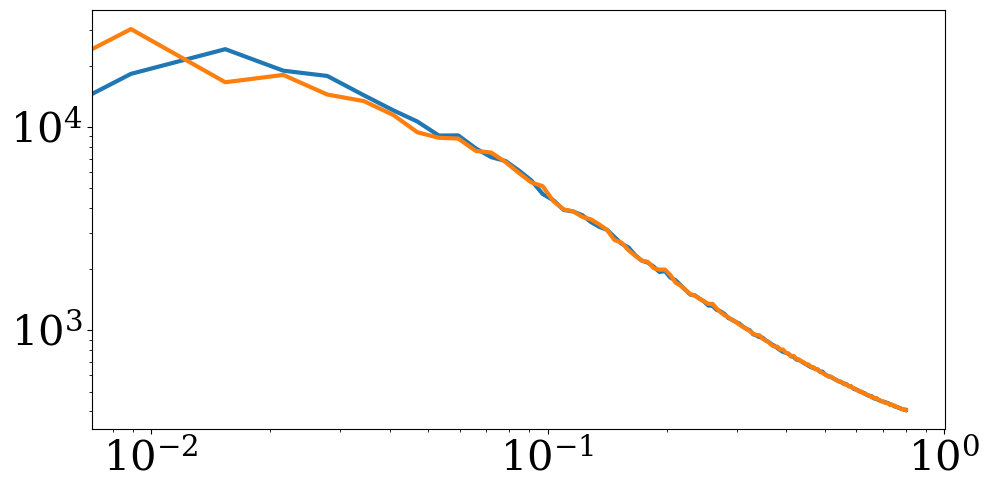

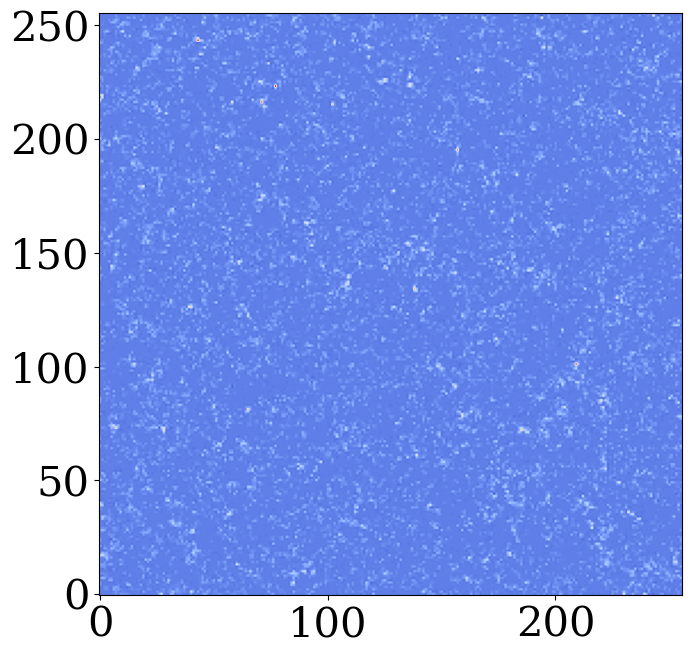

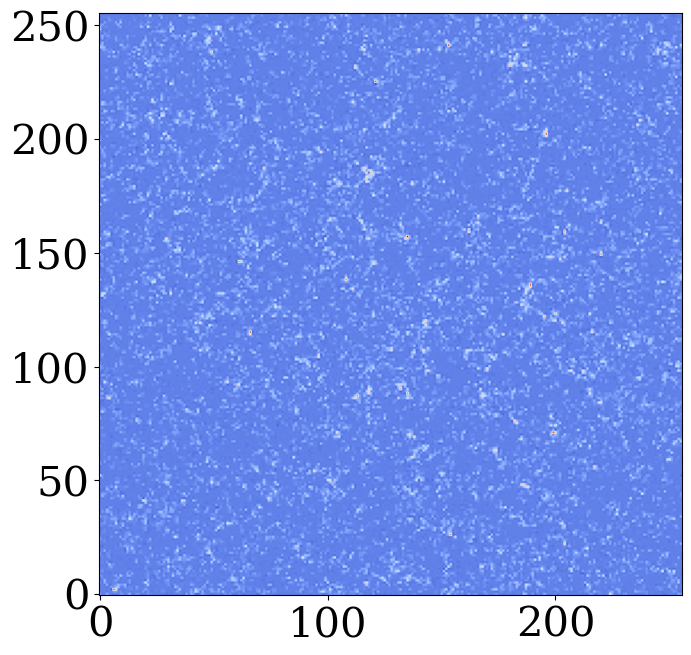

In [16]:
def check_seed_effect():
    fig, ax = plt.subplots(1, 1, figsize=(10, 5))
    for seed in [4, 48]:
        cat = generate_lognormal_mock(seed=seed)
        visualize_lognormal_mock(cat)
        plot_power(fig, ax, cat)

check_seed_effect()

## Correlation function:

<WedgeBinnedStatistic: dims: (r: 27), variables: ('corr', 'r')>
<WedgeBinnedStatistic: dims: (r: 27), variables: ('corr', 'r')>


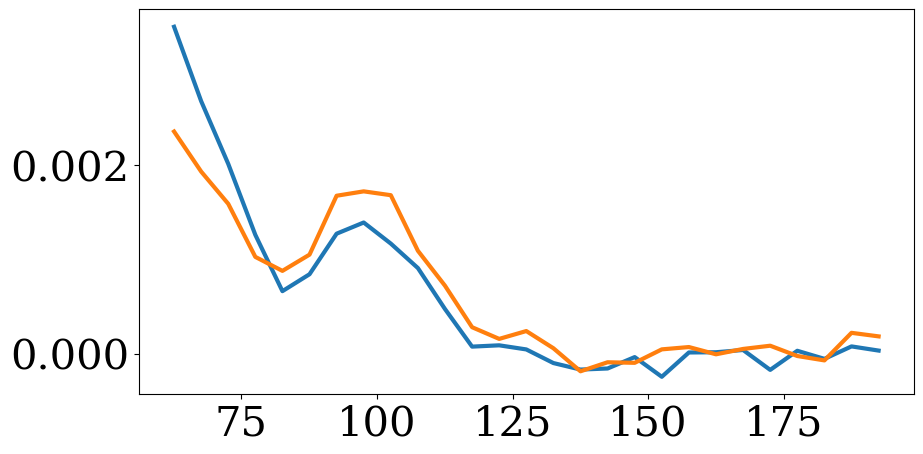

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
cat = generate_lognormal_mock(nbar = 5e-4, BoxSize=1000, seed=4)
r, corr = plot_corr(fig, ax, cat)
cat = generate_lognormal_mock(nbar = 5e-4, BoxSize=1000, seed=48)
r2, corr2 = plot_corr(fig, ax, cat)
del cat

It kind of shows how the random seed has a larger impact on the coorelation fucntion than the power spectrum, specially when `nbar` is small.

Many more runs:

In [11]:
all_corr = np.zeros(shape=(len(all_fnames),99))
r = np.zeros((99,))
for i, fname in enumerate(all_fnames):
    with h5py.File(fname,'r') as f:
        all_corr[i,:] = f['corr'][:]
        r = f['r'][:]
        
    

In [13]:
with h5py.File('./data/mock_lognormal_halos.hdf5','w') as fw:
    fw['corr'] = all_corr
    fw['r'] = r

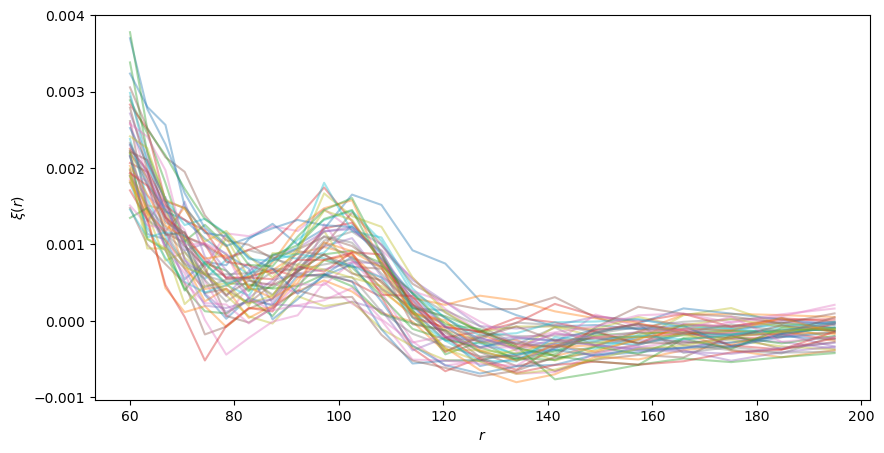

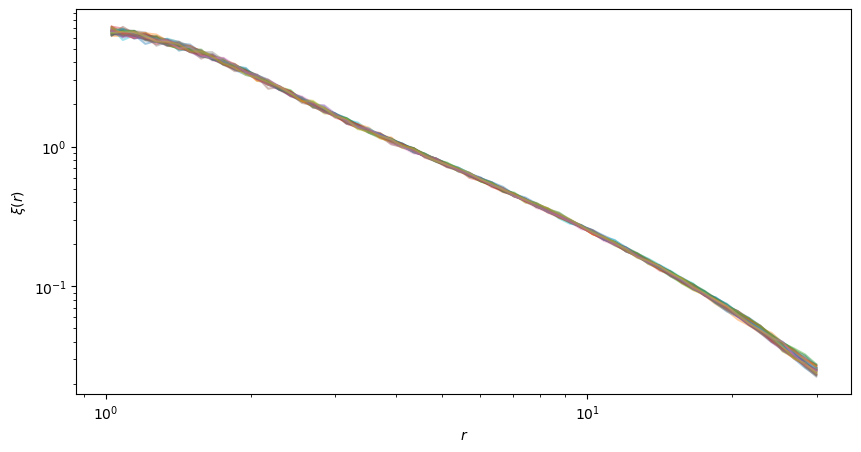

In [24]:
from glob import glob
import h5py
# The data is not 
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
with h5py.File('./data/mock_lognormal_halos.hdf5','r') as f:
    for i in range(f['corr'][:].shape[0]):
        ind = f['r'][:] > 60
        ax.plot(f['r'][ind], f['corr'][i][ind], alpha=0.4)
    ax.set_ylabel(r'$\xi(r)$')
    ax.set_xlabel(r'$r$')

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
with h5py.File('./data/mock_lognormal_halos.hdf5','r') as f:
    for i in range(f['corr'][:].shape[0]):
        ind = f['r'][:] < 30
        ax.plot(f['r'][ind], f['corr'][i][ind], alpha=0.4)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_ylabel(r'$\xi(r)$')
    ax.set_xlabel(r'$r$')